In [6]:
import os
import tempfile
import matplotlib.pyplot as plt
import scvi
import seaborn as sns
import torch
import scanpy as sc
import anndata as ad
import scvelo as scv
import numpy as np
import scanpy.external as sce

In [2]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.3


In [3]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [7]:
import os
os.chdir("/data/dehestani/dehestani/TFvelo/data/10x_mouse_brain/")

In [8]:
adata = ad.read_h5ad("adata_rna.h5ad")

In [9]:
adata

AnnData object with n_obs × n_vars = 5504 × 1891
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'pANN_0.25_0.09_52', 'Mutation', 'SampleID', 'pANN_0.25_0.09_119', 'DF.classifications_0.25_0.09_119', 'pANN_0.25_0.09_88', 'DF.classifications_0.25_0.09_88', 'pANN_0.25_0.09_233', 'DF.classifications_0.25_0.09_233', 'pANN_0.25_0.09_334', 'DF.classifications_0.25_0.09_334', 'pANN_0.25_0.09_28', 'DF.classifications_0.25_0.09_28', 'pANN_0.25_0.09_101', 'DF.classifications_0.25_0.09_101', 'pANN_0.25_0.09_265', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.1', 'seurat_clusters', 'SCT_snn_res.0.2', 'SCT_snn_res.0.3', 'sub.cluster', 'BroadCellType', 'sub.cluster.iPPC', 'celltype', 'umap1', 'umap2', 'slingPseudotime1', 'ident'
    uns: 'X_name'
    obsm: 'HARMONY', 'PCA', 'UMAP'
    layers: 'logcounts'

In [10]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=10e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", layer="counts", n_top_genes=1000, subset=True
)

In [11]:
scvi.model.LinearSCVI.setup_anndata(adata, layer="counts")
model = scvi.model.LinearSCVI(adata, n_latent=10)

In [12]:
model.train(max_epochs=250, plan_kwargs={"lr": 5e-3}, check_val_every_n_epoch=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 250/250: 100%|██████████| 250/250 [04:10<00:00,  1.02s/it, v_num=1, train_loss_step=375, train_loss_epoch=397]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [04:10<00:00,  1.00s/it, v_num=1, train_loss_step=375, train_loss_epoch=397]


<Axes: xlabel='epoch'>

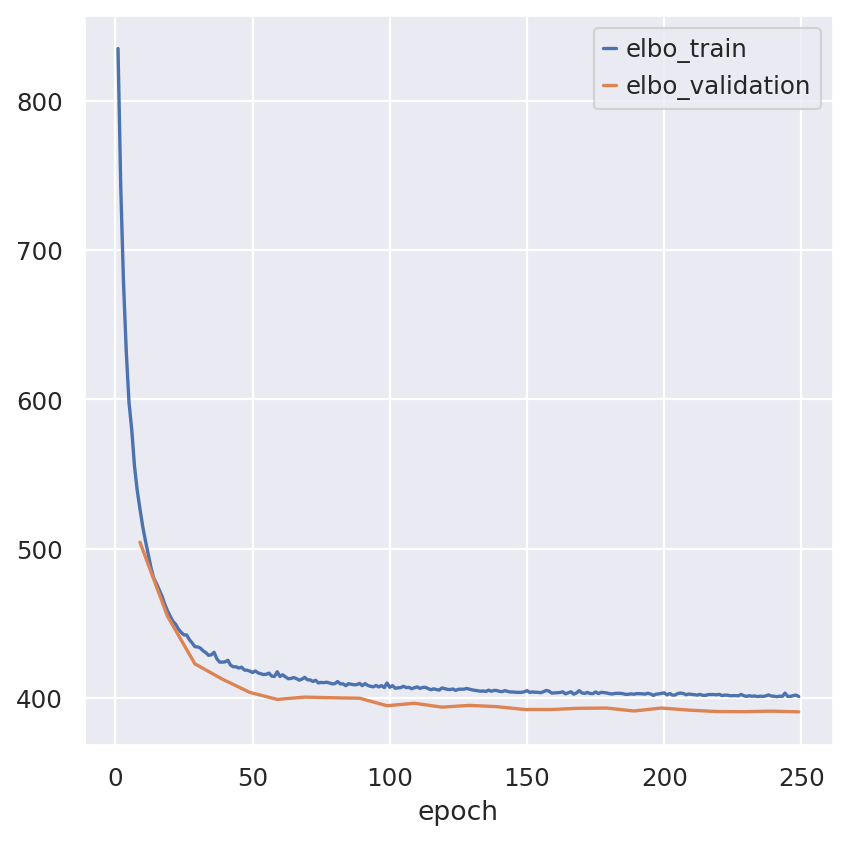

In [13]:
train_elbo = model.history["elbo_train"][1:]
test_elbo = model.history["elbo_validation"]

ax = train_elbo.plot()
test_elbo.plot(ax=ax)

In [14]:
Z_hat = model.get_latent_representation()
for i, z in enumerate(Z_hat.T):
    adata.obs[f"Z_{i}"] = z

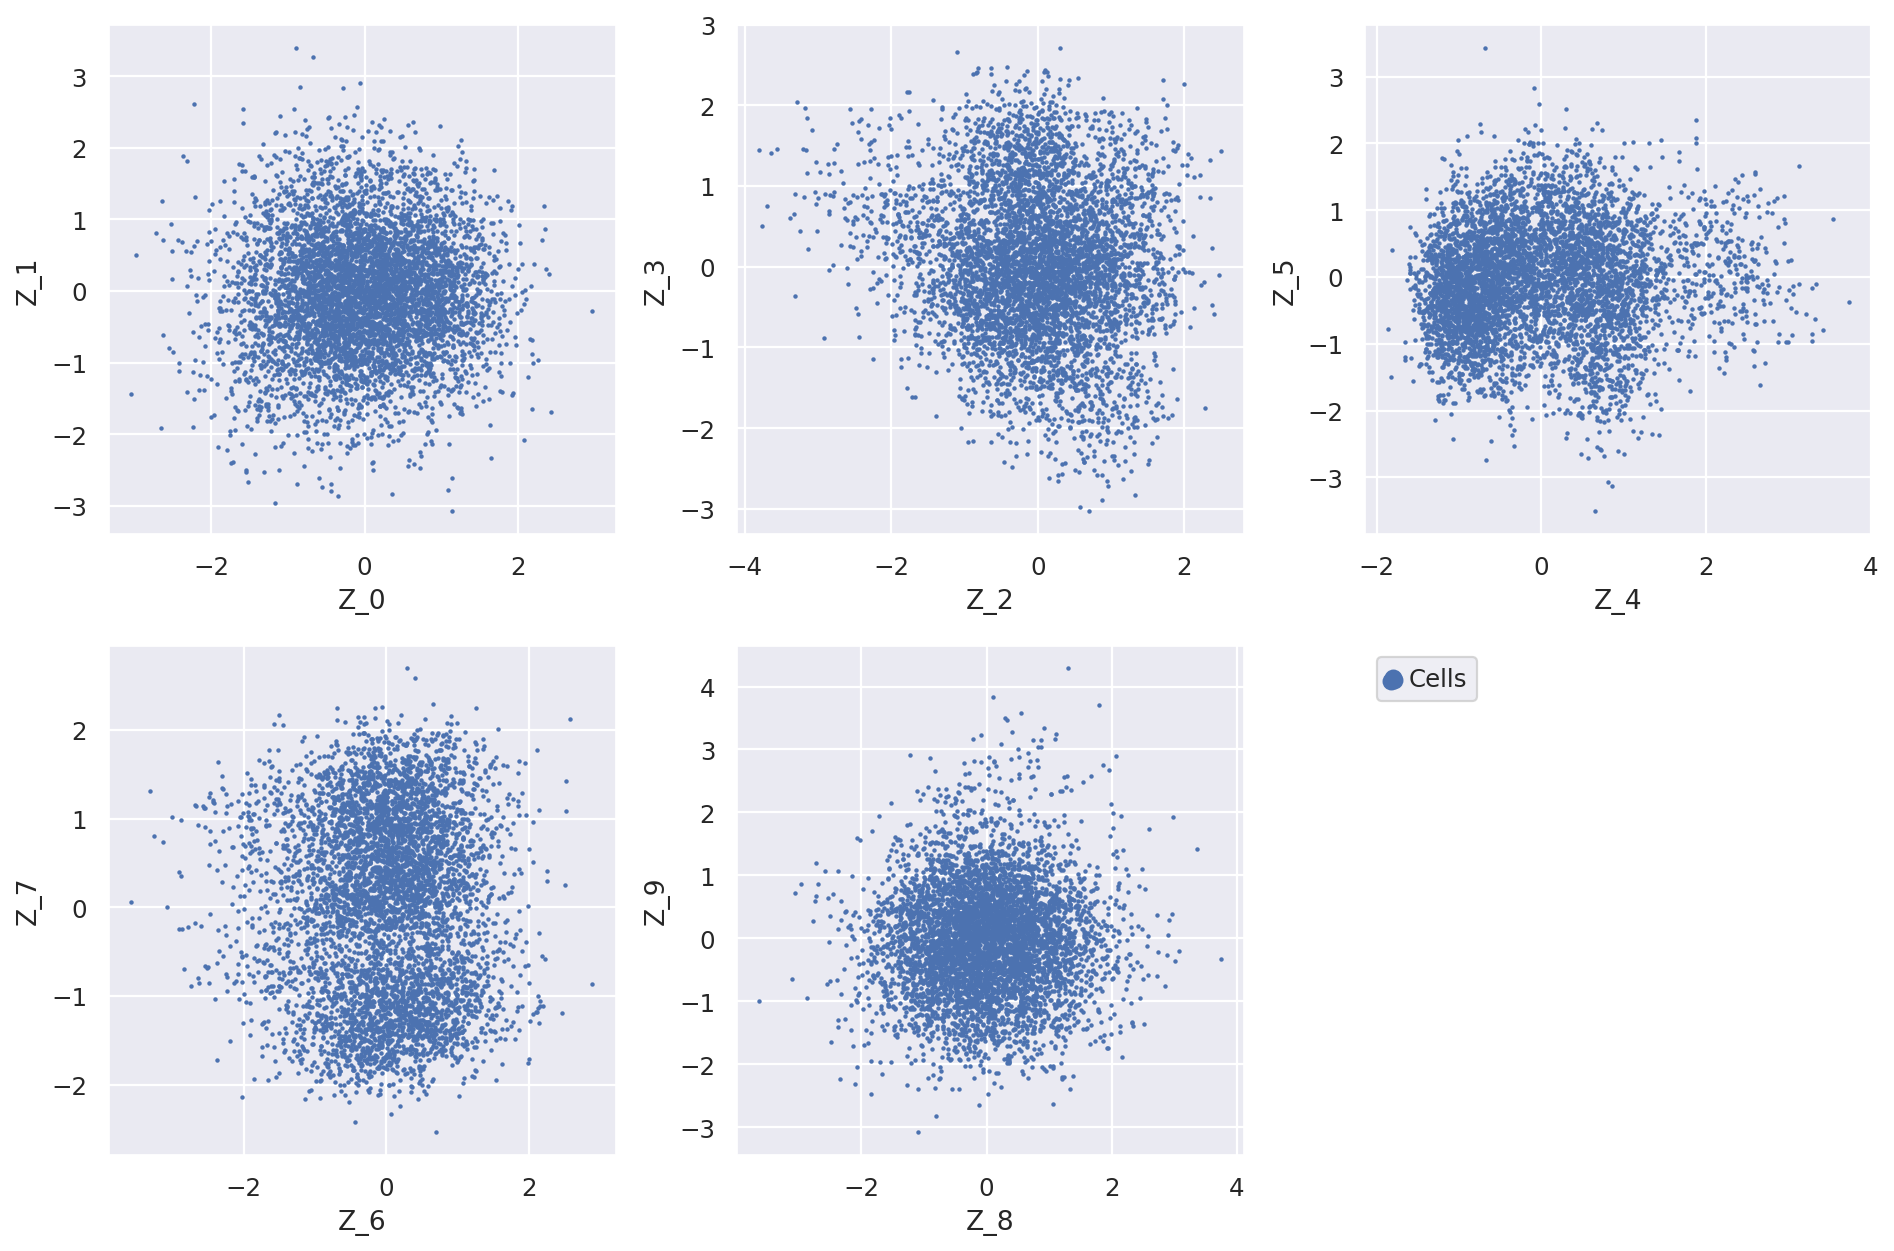

In [15]:
fig = plt.figure(figsize=(12, 8))

for f in range(0, 9, 2):
    plt.subplot(2, 3, int(f / 2) + 1)

    plt.scatter(
        adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], marker=".", s=4, label="Cells"
    )

    plt.xlabel(f"Z_{f}")
    plt.ylabel(f"Z_{f + 1}")

plt.subplot(2, 3, 6)
plt.scatter(
    adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], marker=".", label="Cells", s=4
)
plt.scatter(adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], c="w", label=None)
plt.gca().set_frame_on(False)
plt.gca().axis("off")

lgd = plt.legend(scatterpoints=3, loc="upper left")
for handle in lgd.legendHandles:
    handle.set_sizes([200])


plt.tight_layout()

In [16]:
loadings = model.get_loadings()
loadings.head()

Z_0       Z_1       Z_2       Z_3       Z_4       Z_5  \
MEGF6           -0.305686 -0.272237 -0.418212  0.165230 -0.158874  0.166095   
ENSG00000238260  0.232593 -0.112343 -0.387854 -0.583561  0.351727  0.165038   
LNCTAM34A        0.135587  0.035427  0.059274 -0.256664 -0.110123 -0.117146   
AGTRAP           0.023607 -0.155196  0.126717 -0.184663  0.228794  0.120262   
IFNLR1          -0.150549 -0.147165  0.062397 -0.151335  0.050769  0.007419   

                      Z_6       Z_7       Z_8       Z_9  
MEGF6            0.155476 -0.284173  0.419169 -0.397029  
ENSG00000238260  0.271221 -0.214774  0.308176 -0.326711  
LNCTAM34A        0.097094  0.063738 -0.101688 -0.044584  
AGTRAP           0.169182 -0.581062  0.145654  0.112598  
IFNLR1           0.203957 -0.265871  0.342193 -0.398232

In [17]:
print(
    "Top loadings by magnitude\n---------------------------------------------------------------------------------------"
)
for clmn_ in loadings:
    loading_ = loadings[clmn_].sort_values()
    fstr = clmn_ + ":\t"
    fstr += "\t".join([f"{i}, {loading_[i]:.2}" for i in loading_.head(5).index])
    fstr += "\n\t...\n\t"
    fstr += "\t".join([f"{i}, {loading_[i]:.2}" for i in loading_.tail(5).index])
    print(
        fstr
        + "\n---------------------------------------------------------------------------------------\n"
    )

Top loadings by magnitude
---------------------------------------------------------------------------------------
Z_0:	LINC02511, -0.94	ENSG00000234446, -0.86	ENSG00000287081, -0.84	LINC02796, -0.81	EDN1, -0.8
	...
	A2M, 0.76	ENSG00000267205, 0.79	ENSG00000286251, 0.79	CECR3, 0.83	LDHC, 1.0
---------------------------------------------------------------------------------------

Z_1:	ENSG00000269952, -1.1	ENSG00000258693, -0.79	SLC6A11, -0.78	ENSG00000283148, -0.78	ENSG00000277010, -0.76
	...
	SLC51B, 0.59	ENSG00000282142, 0.62	SNX20, 0.65	ENSG00000288803, 0.65	ENSG00000289426, 0.7
---------------------------------------------------------------------------------------

Z_2:	NEUROG1, -1.8	THCAT155, -1.3	LAMP5, -1.1	IGFBPL1, -1.0	LHX3, -0.97
	...
	ENSG00000254337, 0.76	ENSG00000286134, 0.8	DBX2-AS1, 0.86	HLA-DRB5, 0.89	CD38, 1.0
---------------------------------------------------------------------------------------

Z_3:	ENSG00000289426, -1.1	COL3A1, -0.98	CCDC39-AS1, -0.98	DAW1, -0.96	LI

In [18]:
SCVI_LATENT_KEY = "X_scVI"
SCVI_CLUSTERS_KEY = "leiden_scVI"

adata.obsm[SCVI_LATENT_KEY] = Z_hat
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)
sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.8)

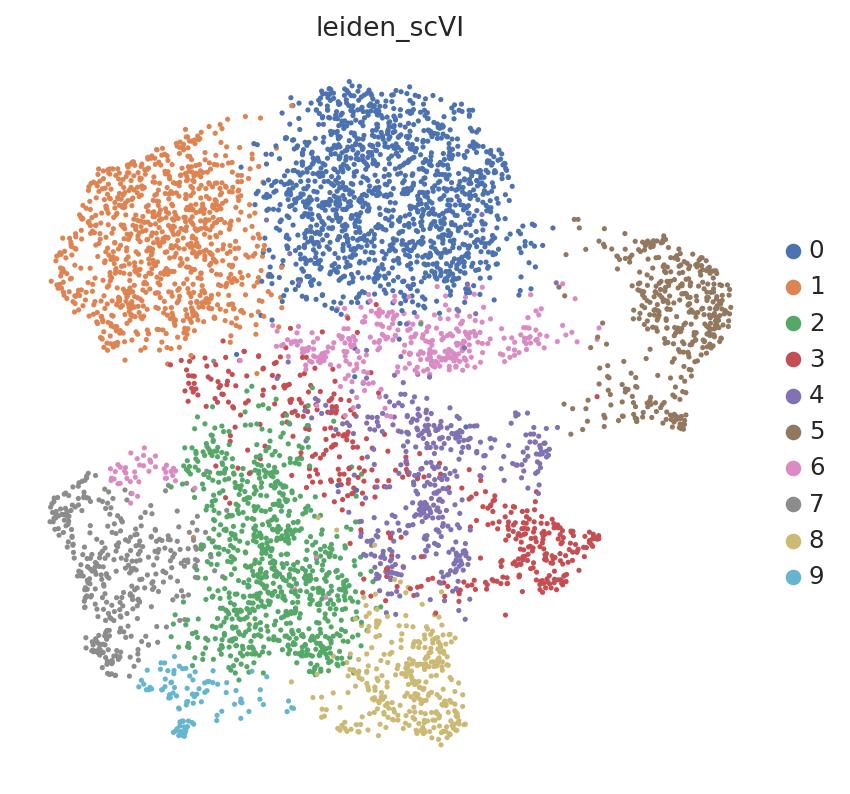

In [19]:
sc.pl.umap(adata, color=[SCVI_CLUSTERS_KEY])

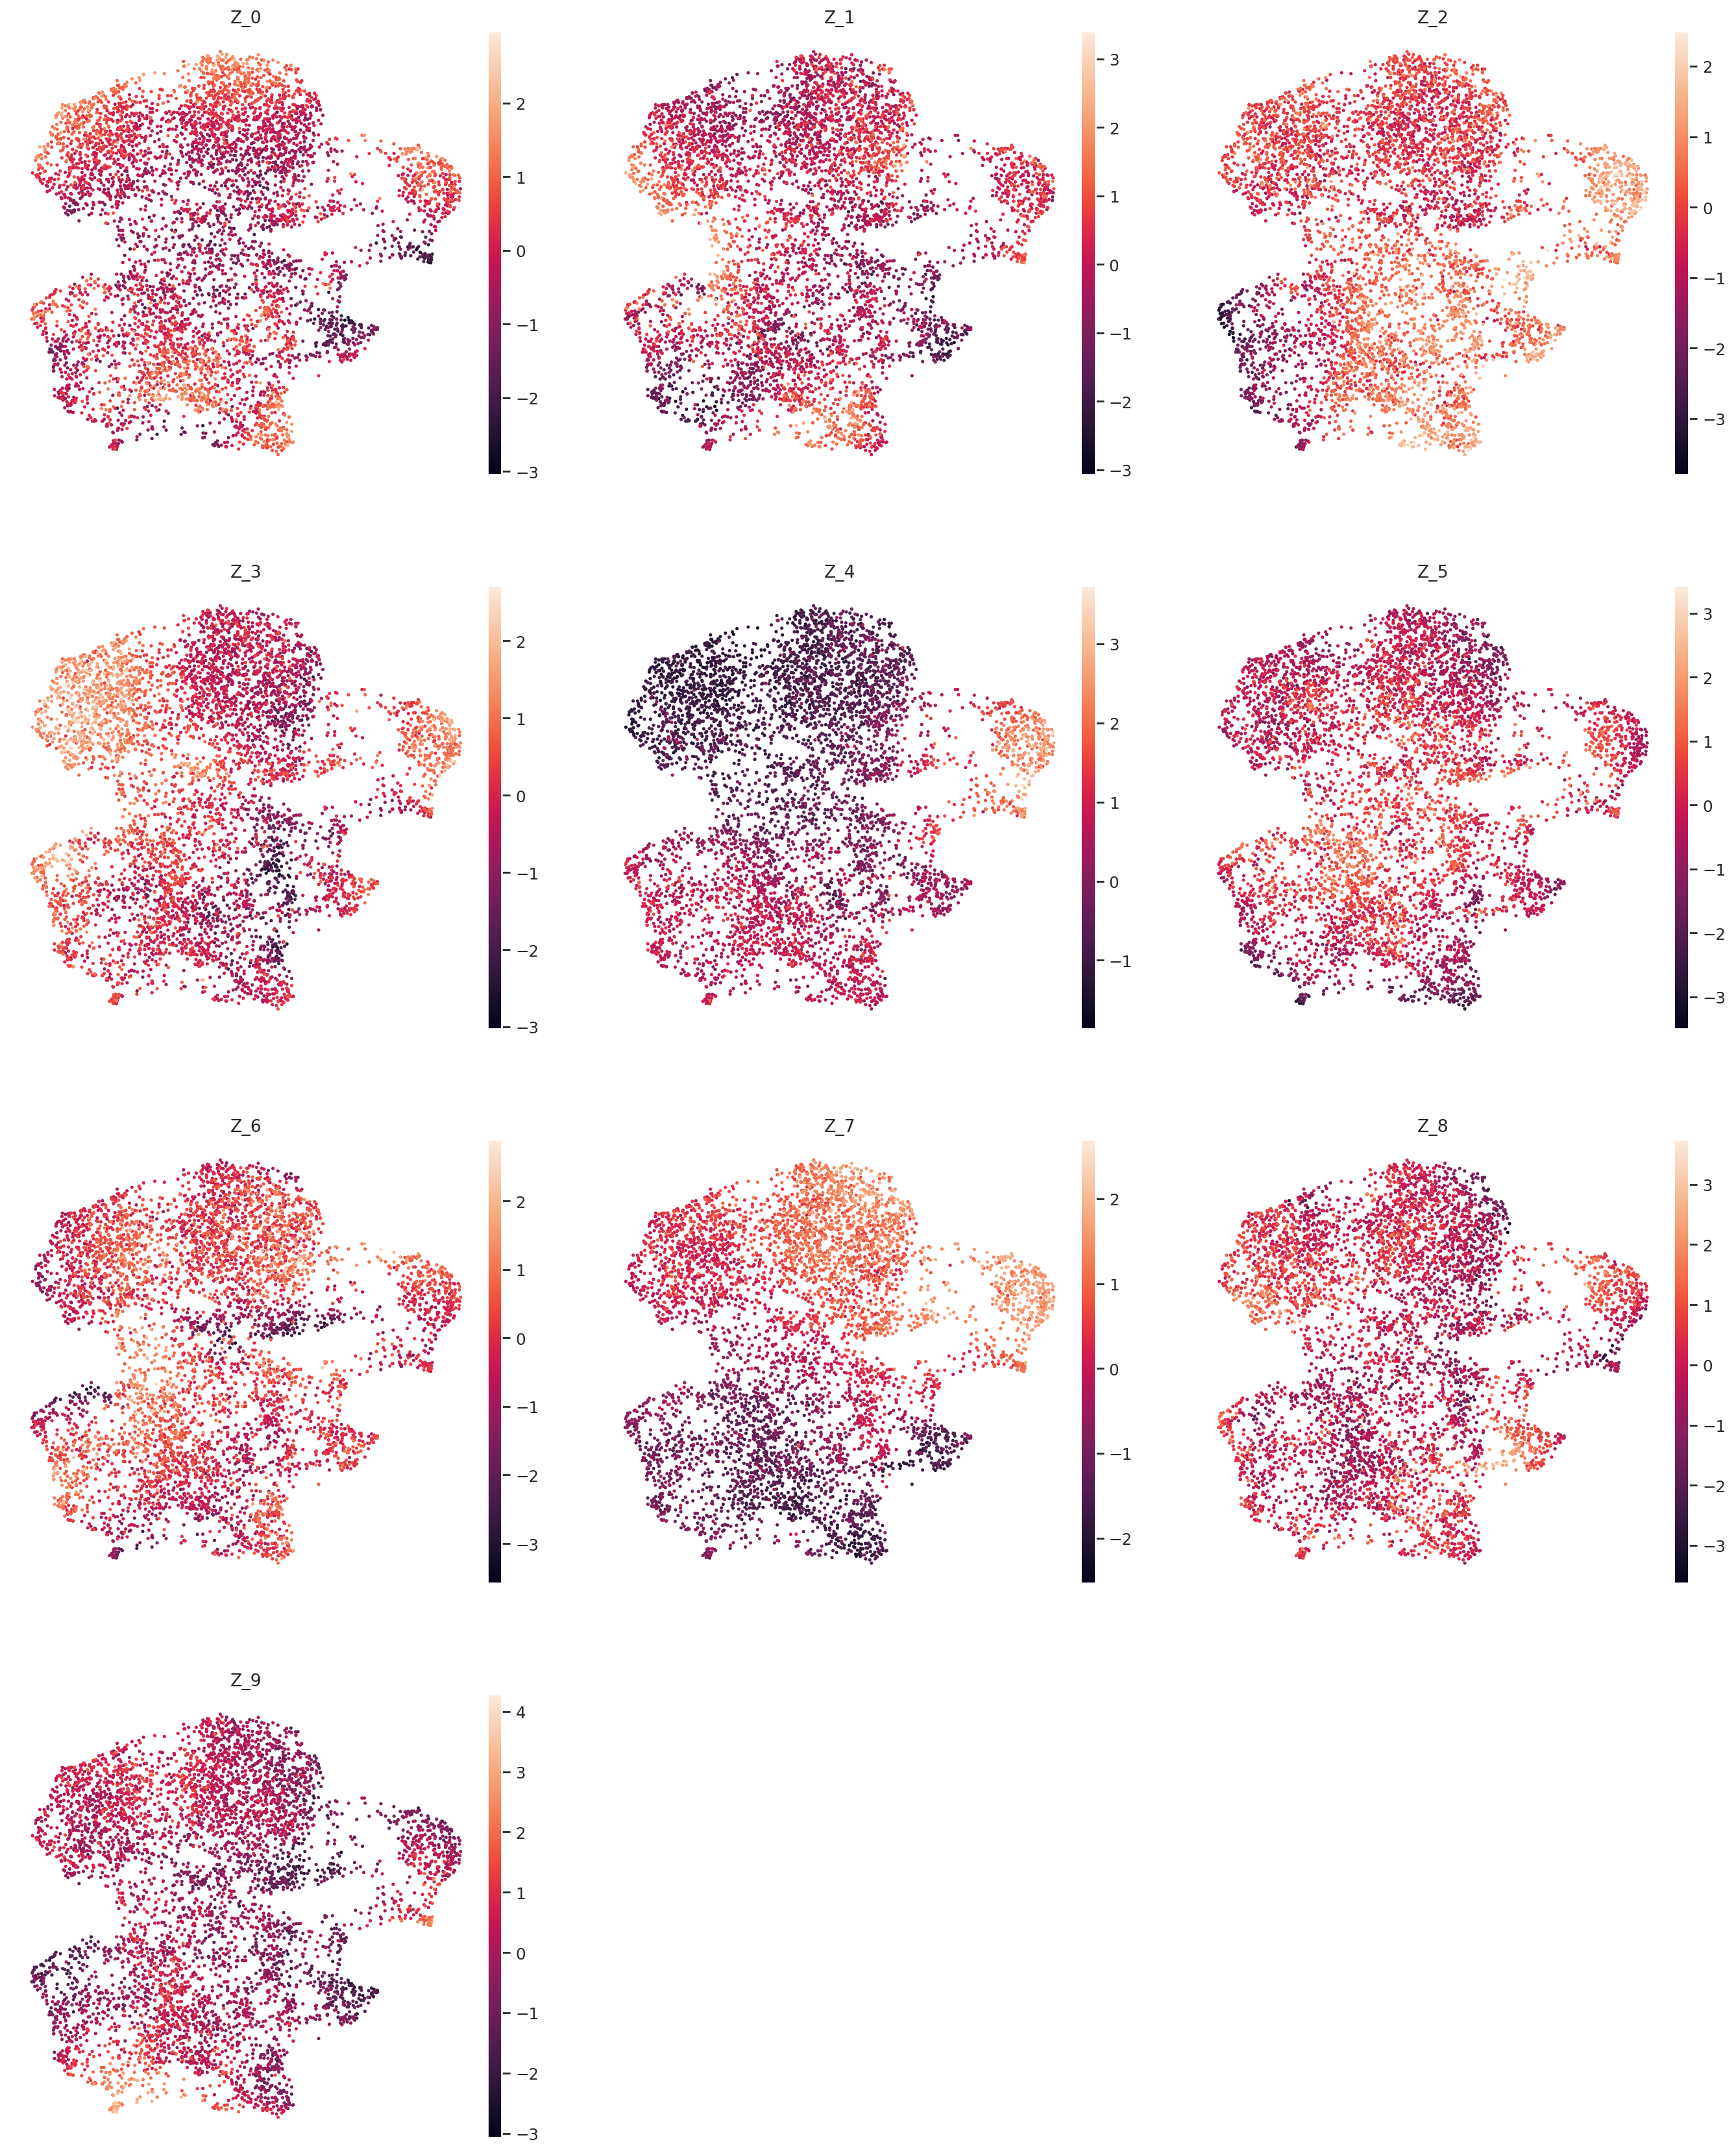

In [20]:
zs = [f"Z_{i}" for i in range(model.n_latent)]
sc.pl.umap(adata, color=zs, ncols=3)